# 🧥 Fashion-MNIST Image Denoising with Autoencoders

## 1. Title & Introduction
In this notebook, we build an **Autoencoder** to denoise **Fashion-MNIST** images.

Autoencoders are neural networks that learn to reconstruct inputs. By training with noisy images as input and clean images as target,
they can effectively denoise images.


**Problem**: Given a noisy clothing image, reconstruct the clean image.

- **Dataset**: Fashion-MNIST (60k training, 10k testing images).
- **Method**: Autoencoder (Encoder + Decoder).
- **Noise Model**: Gaussian noise added to inputs.


## 2. Theory

- **Autoencoder**: Neural network that learns to reconstruct inputs.
- **Encoder**: Compresses input → latent code.
- **Decoder**: Reconstructs input from latent.
- **Loss Function**: Mean Squared Error (MSE).
- **Denoising**: Train with `(noisy → clean)` pairs so network learns to ignore noise.


## 3. Dataset Preparation
Load Fashion-MNIST, normalize, and add Gaussian noise.
- Dataset: Fashion-MNIST 28x28 grayscale images (10 classes).
- Normalization: scale pixel values to [0,1].
- Noise: Gaussian noise added to inputs.

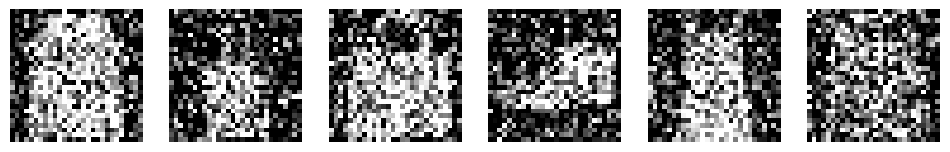

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

# Add Gaussian noise
def add_noise(imgs):
    noisy = imgs + 0.5*torch.randn_like(imgs)
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

images, _ = next(iter(trainloader))
noisy_images = add_noise(images)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,6, figsize=(12,2))
for i in range(6):
    axes[i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()

## 4. Autoencoder Model
Define encoder and decoder using fully connected layers.
#### Encoder:
- Linear(784 -> 128), ReLU
- Linear(128 -> 64), ReLU
- Linear(64 -> 32)
#### Decoder:
- Linear(32 -> 64), ReLU
- Linear(64 -> 128), ReLU
- Linear(128 -> 784), Sigmoid


In [3]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


## 5. Training
Train the autoencoder to minimize reconstruction error (MSE).
- Optimizer: Adam (lr=0.001)
- Loss: Mean Squared Error (MSE)
- Epochs: 10 typical

In [4]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, _ in trainloader:
        noisy = add_noise(images)
        images = images.view(images.size(0), -1)
        noisy = noisy.view(noisy.size(0), -1)

        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss/len(trainloader))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}")

Epoch 1/10, Loss: 0.0502
Epoch 2/10, Loss: 0.0277
Epoch 3/10, Loss: 0.0250
Epoch 4/10, Loss: 0.0238
Epoch 5/10, Loss: 0.0228
Epoch 6/10, Loss: 0.0220
Epoch 7/10, Loss: 0.0215
Epoch 8/10, Loss: 0.0211
Epoch 9/10, Loss: 0.0207
Epoch 10/10, Loss: 0.0203


## 6. Evaluation
Test the autoencoder on noisy test images.
- Input: noisy Fashion-MNIST images.
- Output: denoised reconstructed images.
- Compare: [Original | Noisy | Denoised].

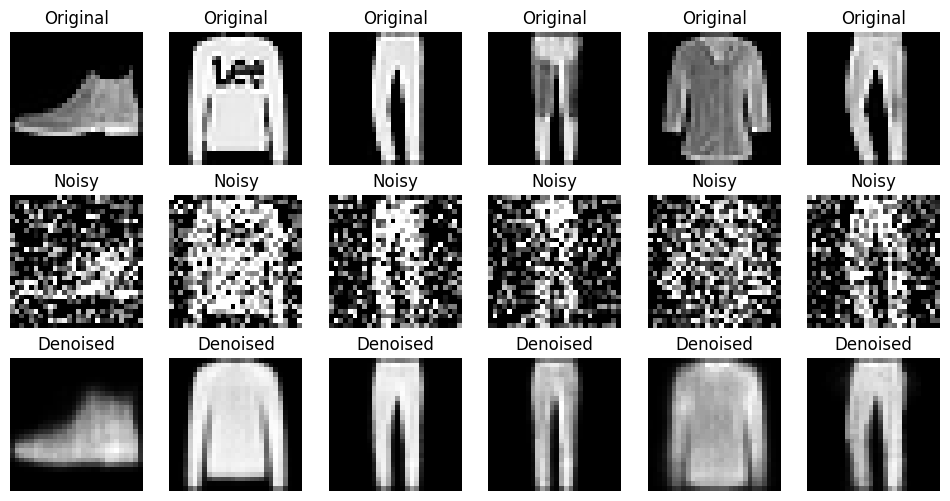

In [5]:
model.eval()
images, _ = next(iter(testloader))
noisy = add_noise(images)
noisy_flat = noisy.view(noisy.size(0), -1)
with torch.no_grad():
    outputs = model(noisy_flat)
outputs = outputs.view(-1, 1, 28, 28)

fig, axes = plt.subplots(3,6, figsize=(12,6))
for i in range(6):
    axes[0,i].imshow(images[i].squeeze(), cmap='gray')
    axes[0,i].set_title("Original")
    axes[0,i].axis('off')

    axes[1,i].imshow(noisy[i].squeeze(), cmap='gray')
    axes[1,i].set_title("Noisy")
    axes[1,i].axis('off')

    axes[2,i].imshow(outputs[i].squeeze(), cmap='gray')
    axes[2,i].set_title("Denoised")
    axes[2,i].axis('off')
plt.show()

## 7. Visualization
Visual comparison of Original vs Noisy vs Denoised images.
- Row 1: Original clean images.
- Row 2: Noisy inputs.
- Row 3: Autoencoder denoised outputs.


## 8. Learning Curves
Plot training loss over epochs.


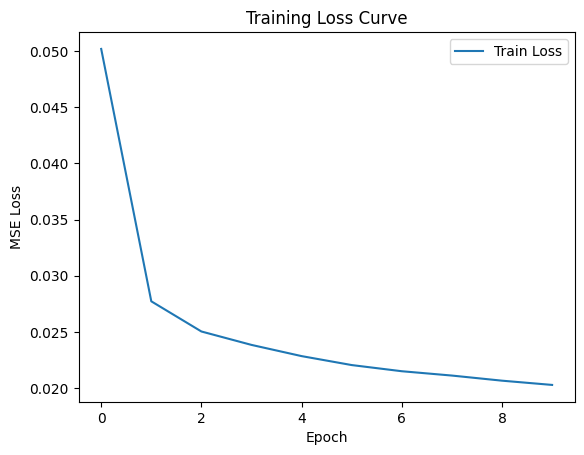

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('Training Loss Curve')
plt.legend(); plt.show()

## 9. Saving & Loading
Save and reload the trained autoencoder.


In [7]:
torch.save(model.state_dict(), "fashion_autoencoder.pth")
print("Model saved as fashion_autoencoder.pth")

new_model = Autoencoder()
new_model.load_state_dict(torch.load("fashion_autoencoder.pth"))
new_model.eval()
print("Model loaded successfully!")

Model saved as fashion_autoencoder.pth
Model loaded successfully!


C:\Users\zeelp\AppData\Local\Temp\ipykernel_23044\3706116849.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("fashion_autoencoder.pt

## 10. Conclusion & References

- Autoencoders can denoise Fashion-MNIST images effectively.
- The model learns to reconstruct clean features, ignoring noise.
- Extensions: Convolutional Autoencoders, Variational Autoencoders.

### References
- [Fashion-MNIST Dataset](https://github.com/zalandoresearch/fashion-mnist)
- [PyTorch Docs](https://pytorch.org/tutorials/)
- [Deep Learning Book – Ian Goodfellow](https://www.deeplearningbook.org/)
